In [3]:
import torch
from torchinfo import summary
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import json
from torch.utils.data import DataLoader

from src.data.dataset import LocalImageDataset
from src.model.SharpNet import SharpNet
from src.model.UNetV2 import UNetV2
from src.model.utils import INPUT_DIR, TARGET_DIR, NUM_CHANNELS, get_device
from src.model.train import psnr, save_samples

In [11]:
# load model
# ckpt_path = "../ckpt/ckpt_800"
ckpt_path = "../ckpt/unetv2_1000"
ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
history = ckpt["history"]
# model = SharpNet(NUM_CHANNELS)
model = UNetV2(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS, features=[64, 128])
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
summary(model, input_size=(1, NUM_CHANNELS, 128, 128))

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_7560/3058311685.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=torc

Layer (type:depth-idx)                   Output Shape              Param #
UNetV2                                   [1, 1, 128, 128]          --
├─ModuleList: 1-3                        --                        (recursive)
│    └─DoubleResConv: 2-1                [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         704
│    │    └─Sequential: 3-2              [1, 64, 128, 128]         36,992
├─AvgPool2d: 1-2                         [1, 64, 64, 64]           --
├─ModuleList: 1-3                        --                        (recursive)
│    └─DoubleResConv: 2-2                [1, 128, 64, 64]          --
│    │    └─Sequential: 3-3              [1, 128, 64, 64]          73,984
│    │    └─Sequential: 3-4              [1, 128, 64, 64]          147,712
├─AvgPool2d: 1-4                         [1, 128, 32, 32]          --
├─DoubleResConv: 1-5                     [1, 256, 32, 32]          --
│    └─Sequential: 2-3                   [1, 256, 32,

In [12]:
# load image 131, 0
image_idx = 775
image_name = f"Image_{image_idx}.png"
input_image = Image.open(os.path.join(INPUT_DIR, image_name))
target_image = Image.open(os.path.join(TARGET_DIR, image_name))
input_tensor =  torch.tensor(np.array(input_image, dtype=np.float32)).unsqueeze(0) / 255.0
target_tensor = torch.tensor(np.array(target_image, dtype=np.float32)).unsqueeze(0) / 255.0

# make prediction
output_tensor = model(input_tensor.unsqueeze(0))

# post-process prediction backgroun
# background_threshold = 0.9
# output_tensor = torch.where(output_tensor > background_threshold, torch.tensor(1.0), output_tensor)

# text_threshold = 0.4 
# output_tensor = torch.where(output_tensor < text_threshold, torch.tensor(0.0), output_tensor)


# process before plot
input_image_numpy = (input_tensor).permute(1, 2, 0).detach().numpy()
target_image_numpy = (target_tensor).permute(1, 2, 0).detach().numpy()
output_image_numpy = (output_tensor[0]).permute(1, 2, 0).detach().numpy()


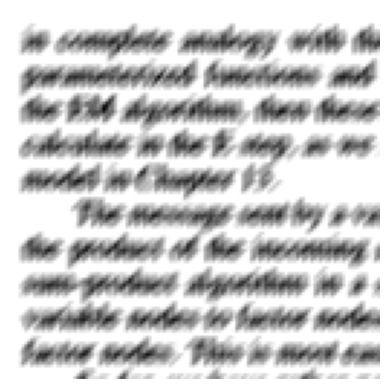

In [13]:
plt.imshow(input_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

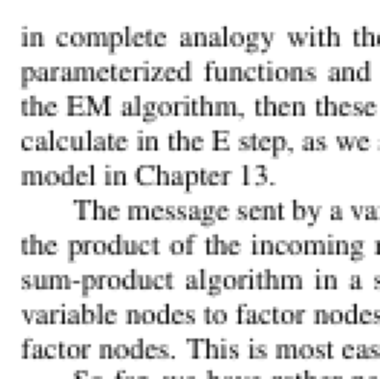

In [14]:
plt.imshow(target_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

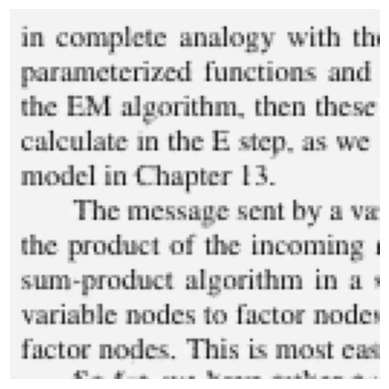

In [15]:
plt.imshow(output_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

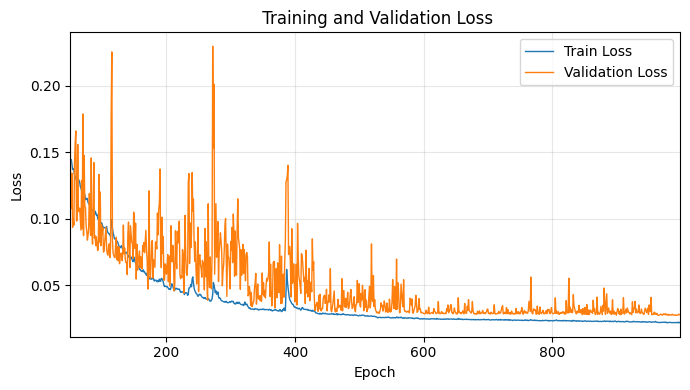

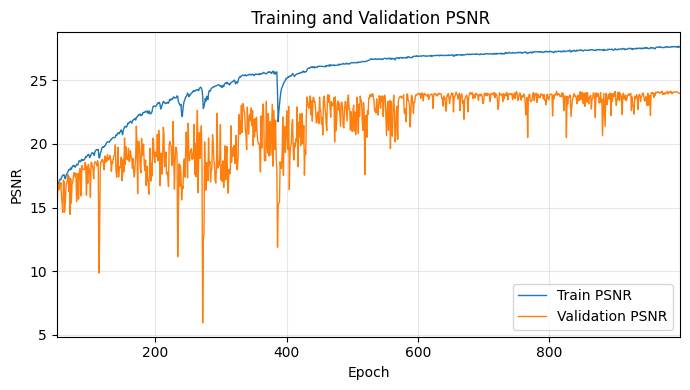

In [26]:
offset = 50
# model_name = "SharpNet"
model_name = ""

# loss
plt.figure(figsize=(7,4))
plt.plot(range(offset, len(history["train_loss"])), history["train_loss"][offset:], label="Train Loss", linewidth=1)
plt.plot(range(offset, len(history["val_loss"])), history["val_loss"][offset:], label="Validation Loss", linewidth=1)

# Set proper axis limits and ticks
plt.xlim(offset, len(history["train_loss"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{model_name} Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Use tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

# PSNR
plt.figure(figsize=(7,4))
plt.plot(range(offset, len(history["train_psnr"])), history["train_psnr"][offset:], label="Train PSNR", linewidth=1)
plt.plot(range(offset, len(history["val_psnr"])), history["val_psnr"][offset:], label="Validation PSNR", linewidth=1)

# Set proper axis limits and ticks
plt.xlim(offset, len(history["train_psnr"]))
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title(f"{model_name} Training and Validation PSNR")
plt.legend()
plt.grid(True, alpha=0.3)

# Use tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [25]:
# pnsr over test data

with open('../model/test_indices.json', 'r') as f:
    test_indices = json.load(f)

test_psnr = []
original_psnr = []
model.eval()
with torch.no_grad():
    for idx in test_indices:
        image_name = f"Image_{idx}.png"
        input_image = Image.open(os.path.join(INPUT_DIR, image_name))
        target_image = Image.open(os.path.join(TARGET_DIR, image_name))
        input_tensor =  torch.tensor(np.array(input_image, dtype=np.float32)).unsqueeze(0) / 255.0
        target_tensor = torch.tensor(np.array(target_image, dtype=np.float32)).unsqueeze(0) / 255.0
        output_tensor = model(input_tensor.unsqueeze(0))

        # background_threshold = 0.9
        # output_tensor = torch.where(output_tensor > background_threshold, torch.tensor(1.0), output_tensor)

        # text_threshold = 0.4 
        # output_tensor = torch.where(output_tensor < text_threshold, torch.tensor(0.0), output_tensor)
        
        # Calculate PSNR
        test_psnr.append(psnr(output_tensor, target_tensor))
        original_psnr.append(psnr(input_tensor, target_tensor))

# Print average PSNR
print(f"Average output PSNR on test set: {np.mean(test_psnr):.2f} dB")
print(f"Average original PSNR on test set: {np.mean(original_psnr):.2f} dB")


Average output PSNR on test set: 27.21 dB
Average original PSNR on test set: 16.97 dB


In [102]:
def save_test_samples(model_name, model, loader, device, output_dir, num_samples=5):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    samples = []

    with torch.no_grad():
        for _, (input_images, target_images) in enumerate(loader):
            input_images = input_images.to(device)
            denoised_images = model(input_images)

            # input, denoised, and target images
            for i in range(min(len(input_images), num_samples - len(samples))):
                samples.append((input_images[i].cpu(), denoised_images[i].cpu(), target_images[i].cpu()))

            if len(samples) >= num_samples:
                break

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, (input_img, denoised_img, target_img) in enumerate(samples):
        axes[i, 0].imshow(input_img.permute(1, 2, 0).numpy(), cmap="gray")
        axes[i, 0].set_title("Input (Blurry)")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(denoised_img.permute(1, 2, 0).numpy(), cmap="gray")
        axes[i, 1].set_title("Model Denoised")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(target_img.permute(1, 2, 0).numpy(), cmap="gray")
        axes[i, 2].set_title("Target (Ground Truth)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{model_name}_test_samples.png")
    plt.savefig(save_path)
    plt.close(fig)

In [103]:
model_name = "UNetV2"
test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=1, shuffle=True)
save_test_samples(model_name, model, test_loader, "cpu", "../sample_data", num_samples=5)


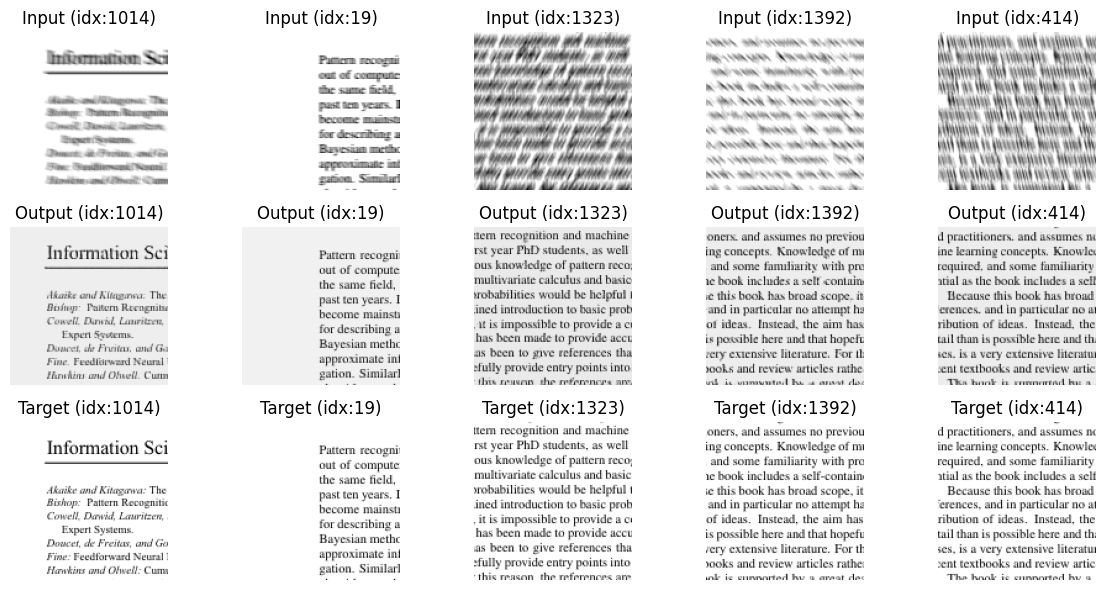

In [31]:
def visualize_image_pairs(model, test_indices, num_samples=3, random_seed=42):
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Get random indices from test set
    selected_indices = np.random.choice(test_indices, num_samples, replace=False)
    
    # Create a figure with 3 rows and num_samples columns
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 6))
    
    model.eval()
    with torch.no_grad():
        for idx, image_idx in enumerate(selected_indices):
            image_name = f"Image_{idx}.png"
            input_image = Image.open(os.path.join(INPUT_DIR, image_name))
            target_image = Image.open(os.path.join(TARGET_DIR, image_name))
            input_tensor =  torch.tensor(np.array(input_image, dtype=np.float32)).unsqueeze(0) / 255.0
            target_tensor = torch.tensor(np.array(target_image, dtype=np.float32)).unsqueeze(0) / 255.0
            output_tensor = model(input_tensor.unsqueeze(0))

            input_image_numpy = (input_tensor).permute(1, 2, 0).detach().numpy()
            target_image_numpy = (target_tensor).permute(1, 2, 0).detach().numpy()
            output_image_numpy = (output_tensor[0]).permute(1, 2, 0).detach().numpy()
            
            # plot images
            axes[0, idx].imshow(input_image_numpy, cmap='gray')
            axes[0, idx].set_title(f'Input (idx:{image_idx})')
            axes[0, idx].axis('off')
            
            axes[1, idx].imshow(output_image_numpy, cmap='gray')
            axes[1, idx].set_title(f'Output (idx:{image_idx})')
            axes[1, idx].axis('off')
            
            axes[2, idx].imshow(target_image_numpy, cmap='gray')
            axes[2, idx].set_title(f'Target (idx:{image_idx})')
            axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

    return fig
    

# Call the function to visualize 3 random pairs
sample_fig = visualize_image_pairs(model, test_indices, num_samples=5)
sample_fig.savefig(f"../sample_data_visualization_2.png", dpi=300)